# ChatGPT Reviews Analysis

### Importing Libraries and Dataset

In [18]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

In [19]:
df = pd.read_csv(r"C:\Users\USER\Downloads\Datasets\chatgpt_reviews.csv")
df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


### Data Exploration

In [20]:
df.shape

(196727, 4)

In [21]:
df.isnull().sum()

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64

In [22]:
df.dtypes

Review Id      object
Review         object
Ratings         int64
Review Date    object
dtype: object

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [24]:
df.describe()

,Ratings
count,196727.000000
mean,4.503535
std,1.083004
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


### Filling Null Values

In [25]:
df['Review'] = df['Review'].astype(str).fillna('')

#### Adding Sentiment labels based on the Review content

In [26]:
from textblob import TextBlob

# function to determine sentiment polarity
def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

# applying sentiment analysis
df['Sentiment'] = df['Review'].apply(get_sentiment)

sentiment_distribution = df['Sentiment'].value_counts()

### Exploratory Data Analysis - EDA

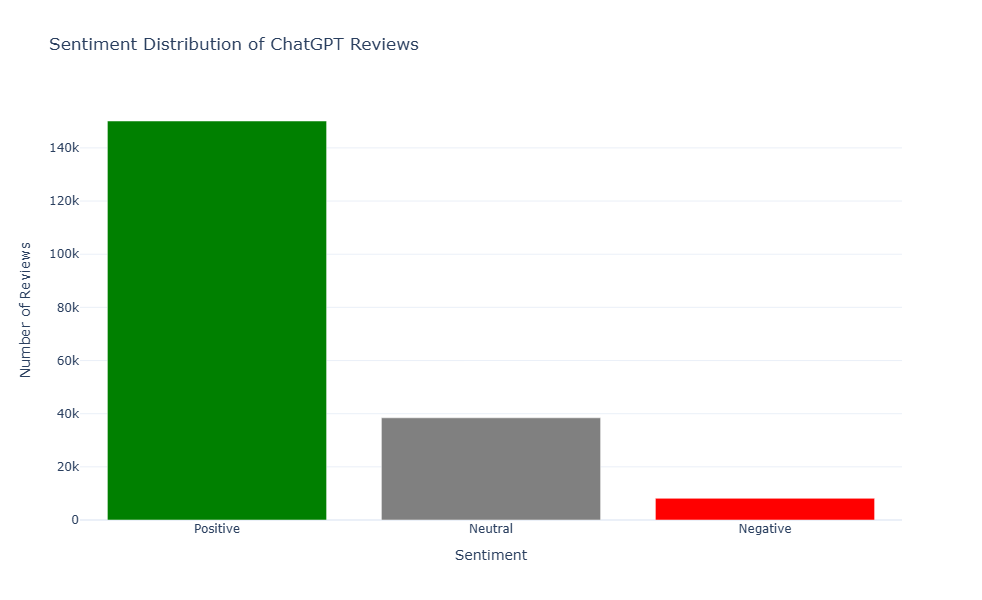

In [27]:
fig = go.Figure(data=[go.Bar(
    x=sentiment_distribution.index,
    y=sentiment_distribution.values,
    marker_color=['green', 'gray', 'red'],
)])

fig.update_layout(
    title='Sentiment Distribution of ChatGPT Reviews',
    xaxis_title='Sentiment',
    yaxis_title='Number of Reviews',
    width=800,
    height=600
)

fig.show()

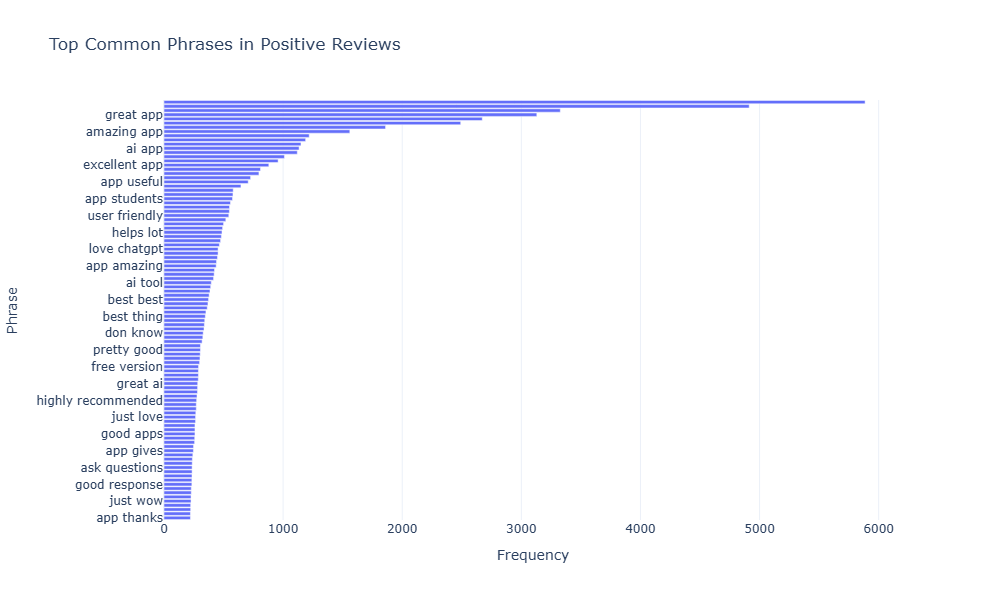

In [28]:
# filter reviews with positive sentiment
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']

# use CountVectorizer to extract common phrases (n-grams)
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=100)
X = vectorizer.fit_transform(positive_reviews)

# sum the counts of each phrase
phrase_counts = X.sum(axis=0)
phrases = vectorizer.get_feature_names_out()
phrase_freq = [(phrases[i], phrase_counts[0, i]) for i in range(len(phrases))]

# sort phrases by frequency
phrase_freq = sorted(phrase_freq, key=lambda x: x[1], reverse=True)

phrase_df = pd.DataFrame(phrase_freq, columns=['Phrase', 'Frequency'])

fig = px.bar(phrase_df,
             x='Frequency',
             y='Phrase',
             orientation='h',
             title='Top Common Phrases in Positive Reviews',
             labels={'Phrase': 'Phrase', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Phrase',
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

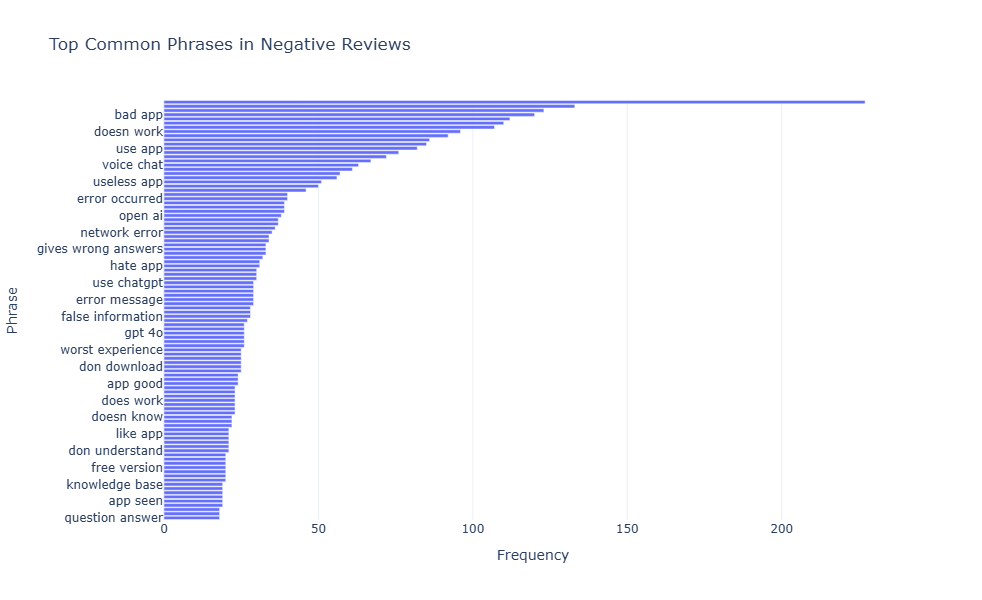

In [29]:
# filter reviews with negative sentiment
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']

# use CountVectorizer to extract common phrases (n-grams) for negative reviews
X_neg = vectorizer.fit_transform(negative_reviews)

# sum the counts of each phrase in negative reviews
phrase_counts_neg = X_neg.sum(axis=0)
phrases_neg = vectorizer.get_feature_names_out()
phrase_freq_neg = [(phrases_neg[i], phrase_counts_neg[0, i]) for i in range(len(phrases_neg))]

# sort phrases by frequency
phrase_freq_neg = sorted(phrase_freq_neg, key=lambda x: x[1], reverse=True)

phrase_neg_df = pd.DataFrame(phrase_freq_neg, columns=['Phrase', 'Frequency'])

fig = px.bar(phrase_neg_df,
             x='Frequency',
             y='Phrase',
             orientation='h',
             title='Top Common Phrases in Negative Reviews',
             labels={'Phrase': 'Phrase', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Phrase',
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

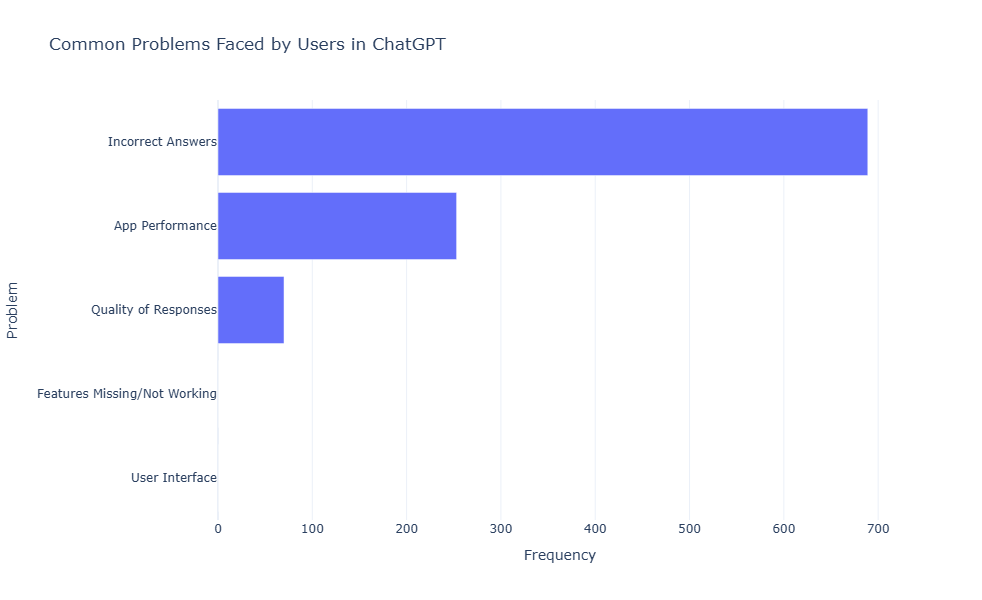

In [30]:
# grouping similar phrases into broader problem categories
problem_keywords = {
    'Incorrect Answers': ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance': ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interface': ['interface', 'UI', 'difficult to use', 'confusing', 'layout'],
    'Features Missing/Not Working': ['feature missing', 'not working', 'missing', 'broken', 'not available'],
    'Quality of Responses': ['bad response', 'useless', 'poor quality', 'irrelevant', 'nonsense']
}

# initialize a dictionary to count problems
problem_counts = {key: 0 for key in problem_keywords.keys()}

# count occurrences of problem-related phrases in negative reviews
for phrase, count in phrase_freq_neg:
    for problem, keywords in problem_keywords.items():
        if any(keyword in phrase for keyword in keywords):
            problem_counts[problem] += count
            break

problem_df = pd.DataFrame(list(problem_counts.items()), columns=['Problem', 'Frequency'])

fig = px.bar(problem_df,
             x='Frequency',
             y='Problem',
             orientation='h', 
             title='Common Problems Faced by Users in ChatGPT',
             labels={'Problem': 'Problem', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

fig.update_layout(
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis_title='Frequency',
    yaxis_title='Problem',
    yaxis={'categoryorder':'total ascending'}  
)

fig.show()

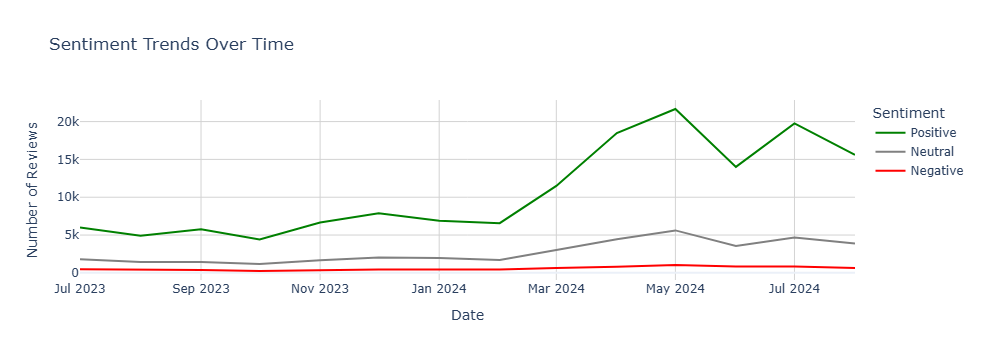

In [31]:
# convert 'Review Date' to datetime format
df['Review Date'] = pd.to_datetime(df['Review Date'])

# aggregate sentiment counts by date
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)

# convert the period back to datetime for plotting
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Positive'],
                         mode='lines', name='Positive', line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Neutral'],
                         mode='lines', name='Neutral', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Negative'],
                         mode='lines', name='Negative', line=dict(color='red')))

fig.update_layout(
    title='Sentiment Trends Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',  
    paper_bgcolor='white',  
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True, gridcolor='lightgray'), 
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()

#### Promoters: Respondents who provide a score of 9 or 10.
#### Passives: Respondents who provide a score of 7 or 8.
#### Detractors: Respondents who provide a score between 0 and 6.

####                                   NPS= %Promoters − %Detractors

In [32]:
# define the categories based on the ratings
df['NPS Category'] = df['Ratings'].apply(lambda x: 'Promoter' if x == 5 else ('Passive' if x == 4 else 'Detractor'))

# calculate the percentage of each category
nps_counts = df['NPS Category'].value_counts(normalize=True) * 100

# calculate NPS
nps_score = nps_counts.get('Promoter', 0) - nps_counts.get('Detractor', 0)

# display the NPS Score
nps_score

64.35313912172705

### The Net Promoter Score (NPS) for ChatGPT, based on the ratings provided in the dataset, is approximately 64.35. 
### It indicates a strong likelihood that users would recommend ChatGPT to others, 
### as a score above 50 is generally considered excellent.